<a href="https://colab.research.google.com/github/ArielFerreiro/ar-stamp-checker/blob/main/attempt.01/03_InceptionNet_NoAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the imaged croped and without augmentation. We create a model using CNN inception architecture pre-trained with imagenet and evaluate the accuracy results to get fake vs genuine stamps.

In [16]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Notebook Imports

In [18]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model,Sequential
from keras.layers.core import Dense, Flatten, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D, Input, Add
import numpy as np
import pickle

#### Global Params


In [38]:
results_path = 'drive/My Drive/Colab Notebooks/stamps/results/'
models_path = 'drive/My Drive/Colab Notebooks/stamps/models/'
test_path = 'drive/My Drive/Colab Notebooks/stamps/test/'

#### Data Load

In [20]:
with open(results_path+"stamps_299.pkl","rb") as f:
    (stamps_df, y) = pickle.load(f)

#### Model Creation

In [21]:
preproc=InceptionResNetV2(include_top = False, pooling = None, weights="imagenet",input_shape=(299, 299, 3))

In [22]:
# Fix the transfer layers not to be trained
for layer in preproc.layers:
    layer.trainable=False

In [23]:
# Dictionary of Layers
outputs_dict = dict([(layer.name, layer.output) for layer in preproc.layers])

In [24]:
net = BatchNormalization(axis=3)(outputs_dict['conv_7b_ac']) 
net=Flatten()(net)
net=Dense(units=256)(net)
net = Activation('relu')(net)
#net=Dropout(0.3)(net)
net=Dense(units=256)(net)
net = Activation('relu')(net)
#net=Dropout(0.3)(net)

# USES Softmax as it is a requirement for the TF Lite add-in used in the mobile app
net=Dense(units=2, activation = 'softmax', kernel_regularizer=keras.regularizers.L2(l2=0.02))(net)
 
model=Model(preproc.inputs,net)
#model.summary()

In [25]:
# Callbacks
checkpoint_file='checkpoint.pmi-cnn-Inception.hdf5'
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [26]:
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', keras.metrics.AUC()])

In [27]:
epocs = 50
# Move the y-true to categorical
y_categorical = keras.utils.to_categorical(y) 

In [28]:
stamps_df.shape

(1888, 299, 299, 3)

In [29]:
y_categorical.shape

(1888, 2)

In [30]:
history = model.fit(x= stamps_df, y=y_categorical,
                    epochs=epocs, verbose=1, 
                    validation_split=0.2,
                    callbacks=[checkpointer, earlystop])

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 8.5329 - accuracy: 0.7344 - auc_1: 0.7647
Epoch 00001: val_accuracy improved from -inf to 0.43122, saving model to checkpoint.pmi-cnn-Inception.hdf5
48/48 [==============================] - 23s 485ms/step - loss: 8.5329 - accuracy: 0.7344 - auc_1: 0.7647 - val_loss: 8.1352 - val_accuracy: 0.4312 - val_auc_1: 0.4112
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 1.4280 - accuracy: 0.8252 - auc_1: 0.8775
Epoch 00002: val_accuracy improved from 0.43122 to 0.84656, saving model to checkpoint.pmi-cnn-Inception.hdf5
48/48 [==============================] - 21s 434ms/step - loss: 1.4280 - accuracy: 0.8252 - auc_1: 0.8775 - val_loss: 1.1042 - val_accuracy: 0.8466 - val_auc_1: 0.9041
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 1.1808 - accuracy: 0.8377 - auc_1: 0.8870
Epoch 00003: val_accuracy did not improve from 0.84656
48/48 [==============================] - 18s 378ms/step - loss

In [31]:
# Full Model training el modelo completo
for layer in model.layers:
    layer.trainable=True

In [34]:
# Retrain full model only 20 epochs
history = model.fit(x= stamps_df, y=y_categorical,
          epochs=20, 
          verbose=1, 
          validation_split=0.2,
          callbacks=[checkpointer, earlystop])

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.3136 - accuracy: 0.9093 - auc_1: 0.9684
Epoch 00001: val_accuracy did not improve from 0.97884
48/48 [==============================] - 18s 373ms/step - loss: 0.3136 - accuracy: 0.9093 - auc_1: 0.9684 - val_loss: 0.4593 - val_accuracy: 0.9074 - val_auc_1: 0.9553
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9272 - auc_1: 0.9811
Epoch 00002: val_accuracy did not improve from 0.97884
48/48 [==============================] - 18s 384ms/step - loss: 0.2334 - accuracy: 0.9272 - auc_1: 0.9811 - val_loss: 0.4622 - val_accuracy: 0.9180 - val_auc_1: 0.9464
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.9245 - auc_1: 0.9764
Epoch 00003: val_accuracy did not improve from 0.97884
48/48 [==============================] - 18s 378ms/step - loss: 0.2541 - accuracy: 0.9245 - auc_1: 0.9764 - val_loss: 3.1838 - val_accuracy: 0.4259 - val_auc_1: 0.3810
E

In [37]:
# Save model and weights without training initial layers
for layer in model.layers:
    layer.trainable=False

model_name = 'inception_noaug_softmax_2.h5'

model.save(models_path + model_name)
model.save_weights(models_path + 'weights_' + model_name)

# Test

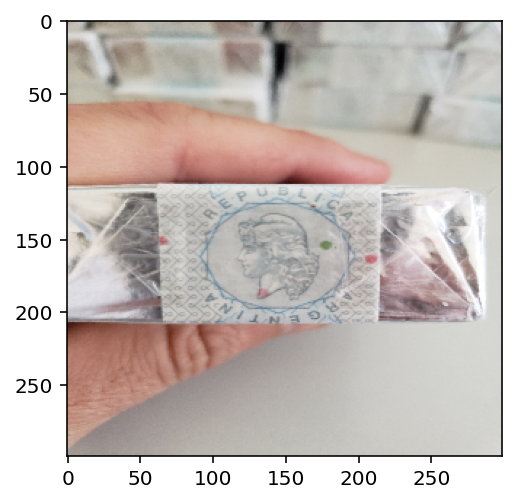

In [39]:
import cv2
import matplotlib.pyplot as plt

imagen_1 = cv2.imread(test_path + 'genuinas_box/20201016_163113.jpg' )
map = cv2.cvtColor(imagen_1, cv2.COLOR_BGR2RGB)
map = cv2.resize(map, dsize=(299,299))
plt.imshow(map)

In [40]:
map = np.expand_dims(map, axis=0)
pred_1 = model.predict(map)
pred_1

# 0-1: genuine
# 1-0: fake

array([[1.0000000e+00, 2.5846268e-15]], dtype=float32)

In [46]:
# TODO CONFUSION MATRIX

# Save model to TFLITE

In [47]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(models_path + 'inception_noaug_sm_2.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp70o5xwcc/assets


In [ ]:
#### DONE v1 29/10/2020
#### Auth: Ariel Ferreiro / Victor Vivas